In [2]:
import pandas as pd
import numpy as np
import os, sys
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer
from datasets import Dataset, Features, ClassLabel,load_dataset,Value
sys.path.append(os.path.abspath(os.path.join('../Dataset')))
warnings.filterwarnings('ignore')

c:\Users\joeli\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importing the dataset

In [3]:
df = pd.read_csv('Dataset/ToS-100.csv',header=0,encoding='utf-8') 
# A, CH, CR, J, LAW, LTD, PINC, TER, USE
data = df[['text', 'label', 'A', 'CH', 'CR', 'J', 'LAW', 'LTD', 'PINC', 'TER', 'USE']]
data

,text,label,A,CH,CR,J,LAW,LTD,PINC,TER,USE
0,websites & communications terms of use,0,0,0,0,0,0,0,0,0,0
1,please read the terms of this entire document ...,0,0,0,0,0,0,0,0,0,0
2,by accessing or signing up to receive communic...,1,0,0,0,0,0,0,0,0,1
3,our websites include multiple domains such as ...,0,0,0,0,0,0,0,0,0,0
4,you may also recognize our websites by nicknam...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20412,you may terminate your account at our service ...,0,0,0,0,0,0,0,0,0,0
20413,the following provisions shall survive termina...,0,0,0,0,0,0,0,0,0,0
20414,"the company reserves the right , at its sole d...",1,0,1,0,0,0,0,0,0,0
20415,"your continued use of the service , following ...",1,0,0,0,0,0,0,0,0,1


(ltd) liability exclusions and limitations

(cr) the provider’s right to unilaterally remove consumer content from the service, including in-app purchases

(ter) the provider’s right to unilaterally terminate the contract

(ch) the provider’s right to unilaterally modify the contract and/or the service

(a) arbitration on disputes arising from the contract

In [4]:
# only keeps the unfair clauses in this five categories
data = df[['text', 'label', 'A', 'CH', 'CR', 'J', 'LAW', 'LTD', 'PINC', 'TER', 'USE']]
unfair_clauses = ['LTD','CR','TER','CH','A']
data['fair'] = 1 - data['label']
data['Others'] = 0
for index, row in data.iterrows():
    if int(row.label) == 1:
        #find which column is 1
        one_column = []
        all_column = []
        for i in range(2, 11):
            try: 
                if row[i] == 1:
                    if (data.columns[i] in unfair_clauses):
                        one_column.append(data.columns[i])
                    all_column.append(data.columns[i])
            except:
                print("error: in row ", index, " column ", i)
                continue
        #check any of one_column is in unfair_clauses
        if len(one_column) == 0 and all_column != []:
            data['Others'][index] = 1
        elif len(one_column) == 0 and all_column == []:
            data['fair'][index] = 1
        elif len(one_column) > 1:
            #random select one element in one_column
            ind = np.random.randint(0,len(one_column),1)[0]
            #set all columns in that rows to 0
            for i in range(2, 11):
                try:
                    data.iloc[index, i] = 0
                except:
                    print("error: in row ", index, " column ", i)
                    continue
            #set the selected column to 1
            data[one_column[ind]][index] = 1
        else:
            continue
            
data.reset_index(drop=True, inplace=True)
# remove '-lrb-' and '-rrb-' in text
data['text'] = data['text'].str.replace('-lrb-', '')
data['text'] = data['text'].str.replace('-rrb-', '')

cleaned_df = data[['text','LTD','CR','TER','CH','A','Others','fair']]

In [6]:
cleaned_df['label'] = 0
for index, row in cleaned_df.iterrows():
    if row.fair != 1:
        argmax = np.argmax(row[1:7])
        cleaned_df['label'][index] = argmax + 1

unfair

In [7]:
cleaned_df[cleaned_df['fair'] == 0]

,text,LTD,CR,TER,CH,A,Others,fair,label
2,by accessing or signing up to receive communic...,0,0,0,0,0,1,0,6
37,you understand and agree that mozilla reserves...,0,1,0,0,0,0,0,2
49,we may suspend or terminate your access to our...,0,0,1,0,0,0,0,3
57,"except as required by law , mozilla and the in...",1,0,0,0,0,0,0,1
58,the collective liability of mozilla and the in...,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
20408,the company reserves the right but has no obl...,0,0,1,0,0,0,0,3
20409,terminate your account or your access to the s...,0,0,1,0,0,0,0,3
20410,monitor or review any content submitted by you...,0,1,0,0,0,0,0,2
20414,"the company reserves the right , at its sole d...",0,0,0,1,0,0,0,4


<BarContainer object of 7 artists>

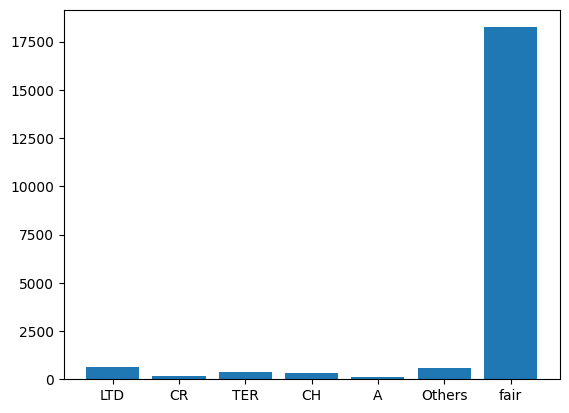

In [11]:
# count samples in each category
class_distribution = [cleaned_df[x].sum() for x in cleaned_df.columns if x not in ['text']]
plt.bar(cleaned_df.columns[1:8], class_distribution[0:7])

<BarContainer object of 6 artists>

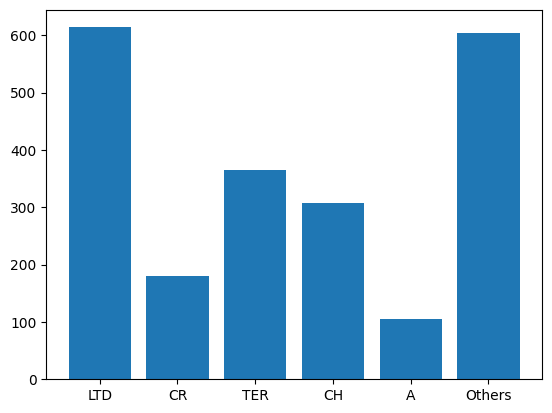

In [12]:
plt.bar(cleaned_df.columns[1:7], class_distribution[0:6])

In [8]:
label_df = cleaned_df[['text','label']]
fair = label_df[label_df['label'] == 0]
unfair = label_df[label_df['label'] != 0]

In [9]:
fair.shape, unfair.shape

((18239, 2), (2178, 2))

In [10]:
#20% test set, 80% train set, split fair and unfair separately
fair_train = fair.sample(frac=0.8,random_state=200)
fair_test = fair.drop(fair_train.index)
unfair_train = unfair.sample(frac=0.8,random_state=200)
unfair_test = unfair.drop(unfair_train.index)
fair_train.shape, fair_test.shape, unfair_train.shape, unfair_test.shape

((14591, 2), (3648, 2), (1742, 2), (436, 2))

In [11]:
train = pd.concat([fair_train, unfair_train])
test = pd.concat([fair_test, unfair_test])
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [25]:
train

,text,label
0,points are awarded to you on a promotional bas...,0
1,4.8 certain services enable children to receiv...,0
2,any rights not expressly granted herein are re...,0
3,when the service is ready for dispatch or deli...,0
4,"de la diputación , edificio inditex , 15143 ar...",0
...,...,...
16328,any disputes arising under or in connection wi...,6
16329,"we reserve the right , at our discretion , to ...",4
16330,to the maximum extent permitted by applicable ...,1
16331,if and as far as necessary to operate the serv...,4


In [213]:
cleaned_df.to_csv('Dataset/ToS-100-cleaned.csv', index=False)

## Fine-Tune

convert from pandas dataframe into huggingface dataset library

In [26]:
class_names = ['fair','LTD', 'CR', 'TER', 'CH', 'A', 'Others']
emotion_features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=7, names=class_names)})
train_ds= Dataset.from_pandas(train,features=emotion_features, split="train")
test_ds= Dataset.from_pandas(test,features=emotion_features, split="test")

auto tokenizer with gpt-2

In [34]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')

def tokenize_function(examples):
  tokenizer.pad_token = tokenizer.eos_token
  return tokenizer(examples["text"], padding="max_length", truncation=True)


train_set = train_ds.map(tokenize_function, batched=True)
test_set = test_ds.map(tokenize_function, batched=True)


















Map: 100%|██████████| 16333/16333 [00:06<00:00, 2509.68 examples/s]





Map: 100%|██████████| 4084/4084 [00:01<00:00, 2527.23 examples/s]


In [35]:
smaller_train_set = train_set.shuffle(seed=42).select(range(1000))
smaller_test_set = test_set.shuffle(seed=42).select(range(200))

In [36]:
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=7)
training_args = TrainingArguments(output_dir="test_trainer")
model.config.pad_token_id = model.config.eos_token_id
metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",num_train_epochs=10,
                                  per_device_train_batch_size=2,gradient_accumulation_steps=4)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=smaller_train_set ,
    eval_dataset=smaller_test_set,
    compute_metrics=compute_metrics,
)
trainer.train()

  9%|▊         | 108/1250 [17:57<3:24:31, 10.75s/it]

KeyboardInterrupt: 